<a href="https://colab.research.google.com/github/KenObata/TISMIR_notebooks/blob/main/week15_RoBERTa_kaggle_batch_layer_everywhere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week15: This notebook uses Pre-Trained RoBERTa

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://github.com/jasonwei20/eda_nlp


### set up

In [1]:
!pip3 install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 5.8 MB/s 


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

def get_balanced_accuracy(model, McNemar, is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning):
  test_y = test.map(map_func_only_y)
  y_category=np.zeros((TEST_SIZE, ))
  counter=0
  for label_tensor in test_y.take(len(test_y)):
    y_test = np.argmax(label_tensor, axis=1)
    for label in y_test:
      y_category[counter]=label
      counter+=1

  X_test, y_test = test.map(map_func_only_X), y_category
  y_predict_test = np.asarray(model.predict(X_test))
  y_predict_test = np.argmax(y_predict_test, axis=1)
  print(classification_report(y_test, y_predict_test) )
  print(balanced_accuracy_score(y_test, y_predict_test))

  McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)] = []
  for ground_truh, pred in zip(y_test, y_predict_test):
        if ground_truh==pred:
          McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)].append(True)
        else:
          McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)].append(False)
  with open(DIR+ "RoBERTa_kaggle_batch_normalize_everywhere_log.txt", "a") as f:
    print("======================================", file=f)
    print("is_fine_tuning?:", is_fine_tuning, "drop_out_rate: ", drop_out_rate, "learning_rate_transfer_learning: ", learning_rate_transfer_learning,
          "learning_rate_fine_tuning: ", learning_rate_fine_tuning, file=f)
    print(classification_report(y_test, y_predict_test) , file=f)
    print(balanced_accuracy_score(y_test, y_predict_test), file=f)

  return balanced_accuracy_score(y_test, y_predict_test), McNemar, y_predict_test

### Data Preparation(Kfold split)

Create dataframe for Gensim

In [4]:
import pandas as pd

DIR = '/content/drive/MyDrive/music4all/'
df_genre_by_lang = pd.read_csv(DIR + 'kaggle/df_kaggle.csv')
df_genre_by_lang = df_genre_by_lang.drop(columns = ['Unnamed: 0'])
df_genre_by_lang

,Genre,Lyrics
0,Hip-Hop,Most folks spend their days daydreaming of fin...
1,Indie,Take your cold hands and put them on my face\n...
2,Metal,Are you ready it's time for war\nWe'll break d...
3,Pop,You ask me why I change the color of my hair\n...
4,Hip-Hop,Do you believe in magic in a young girl's hear...
...,...,...
258117,R&B,I'm the best friend he's got I'd give him the ...
258118,Pop,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
258119,Pop,Forgive me for the things That I never said to...
258120,Indie,The day they found a cure for AIDS The day the...


In [5]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [6]:
data = load_data(df_genre_by_lang["Lyrics"], df_genre_by_lang["Genre"])

In [7]:
data

,texts,labels
0,"[Most, folks, spend, their, days, daydreaming,...",Hip-Hop
1,"[Take, your, cold, hands, and, put, them, on, ...",Indie
2,"[Are, you, ready, it's, time, for, war\nWe'll,...",Metal
3,"[You, ask, me, why, I, change, the, color, of,...",Pop
4,"[Do, you, believe, in, magic, in, a, young, gi...",Hip-Hop
...,...,...
258117,"[I'm, the, best, friend, he's, got, I'd, give,...",R&B
258118,"[Bad, Boys, Blue, ""I, Totally, Miss, You"", I, ...",Pop
258119,"[Forgive, me, for, the, things, That, I, never...",Pop
258120,"[The, day, they, found, a, cure, for, AIDS, Th...",Indie


In [8]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [9]:
type(X)

pandas.core.series.Series

In [10]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [11]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [12]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [     1      2      4 ... 258118 258120 258121] TEST: [     0      3      6 ... 258105 258112 258119]
TRAIN: [     0      1      2 ... 258119 258120 258121] TEST: [     7     15     20 ... 258110 258113 258114]
TRAIN: [     0      1      3 ... 258118 258119 258121] TEST: [     2      5     12 ... 258091 258116 258120]
TRAIN: [     0      2      3 ... 258119 258120 258121] TEST: [     1      8     10 ... 258102 258106 258118]
TRAIN: [     0      1      2 ... 258118 258119 258120] TEST: [     4     13     16 ... 258115 258117 258121]


In [13]:
len(splits)

5

In [14]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(206497,)
(206497,)
(51625,)
(51625,)


In [15]:
split0['X_train']

1         [Take, your, cold, hands, and, put, them, on, ...
2         [Are, you, ready, it's, time, for, war\nWe'll,...
4         [Do, you, believe, in, magic, in, a, young, gi...
5         [People, starin', at, me, as, they, wheel, me,...
7         [Tell, Mel, Shawn, to, come, in\nWord,, yo,, o...
                                ...                        
258116    [It's, complicated, It, always, is, That's, ju...
258117    [I'm, the, best, friend, he's, got, I'd, give,...
258118    [Bad, Boys, Blue, "I, Totally, Miss, You", I, ...
258120    [The, day, they, found, a, cure, for, AIDS, Th...
258121    [Fourth, of, July, has, come,, it's, custom, t...
Name: texts, Length: 206497, dtype: object

In [16]:
split0['y_train']

1         4
2         6
4         3
5         0
7         3
         ..
258116    1
258117    8
258118    7
258120    4
258121    7
Name: labels, Length: 206497, dtype: int8

In [17]:
counter_origin = Counter(df_genre_by_lang['Genre'])
counter_origin = sorted(counter_origin.items(), key= lambda k:k[1])
counter_origin

[('Electronic', 2664),
 ('Country', 2700),
 ('Hip-Hop', 3198),
 ('R&B', 3273),
 ('Indie', 7750),
 ('Folk', 8660),
 ('Jazz', 13974),
 ('Metal', 19943),
 ('Pop', 87405),
 ('Rock', 108555)]

In [18]:
counter_code = Counter(split0['y_train'])
counter_code= sorted(counter_code.items(), key= lambda k:k[1])
counter_code

[(1, 2131),
 (0, 2160),
 (3, 2558),
 (8, 2618),
 (4, 6200),
 (2, 6928),
 (5, 11180),
 (6, 15954),
 (7, 69924),
 (9, 86844)]

In [19]:
code2genre = {
    0: 'Country'
    , 1: 'Electronic'
    , 3:'Hip-Hop'
    , 8:'R&B'
    , 4: 'Indie'
    ,2: 'Folk'
    ,5: 'Jazz'
    ,6: 'Metal'
    ,7: 'Pop'
    ,9: 'Rock'
}
code2genre

{0: 'Country',
 1: 'Electronic',
 3: 'Hip-Hop',
 8: 'R&B',
 4: 'Indie',
 2: 'Folk',
 5: 'Jazz',
 6: 'Metal',
 7: 'Pop',
 9: 'Rock'}

### Use my self programmed balanced accuracy

In [ ]:
metrics = Metrics()
history = model.fit(train, validation_data=val, epochs=10, class_weight=my_weight ,callbacks=[metrics])
metrics.get_data()

Epoch 1/10
339/339 [==============================] - 225s 645ms/step - loss: 0.5565 - categorical_accuracy: 0.3878 - val_loss: 1.9337 - val_categorical_accuracy: 0.3273
Epoch 2/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5397 - categorical_accuracy: 0.3626 - val_loss: 2.0651 - val_categorical_accuracy: 0.2764
Epoch 3/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5375 - categorical_accuracy: 0.3392 - val_loss: 2.0931 - val_categorical_accuracy: 0.2273
Epoch 4/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5378 - categorical_accuracy: 0.3197 - val_loss: 2.0576 - val_categorical_accuracy: 0.2459
Epoch 5/10
339/339 [==============================] - 219s 645ms/step - loss: 0.5333 - categorical_accuracy: 0.3077 - val_loss: 2.0292 - val_categorical_accuracy: 0.2816
Epoch 6/10
339/339 [==============================] - 219s 646ms/step - loss: 0.5373 - categorical_accuracy: 0.2967 - val_loss: 2.1738 - val_categoric

[{'balanced_accuracy': 0.09744849916749872},
 {'balanced_accuracy': 0.10420636932765996},
 {'balanced_accuracy': 0.10970405736872939},
 {'balanced_accuracy': 0.10356561320774078},
 {'balanced_accuracy': 0.10792864804613309},
 {'balanced_accuracy': 0.09168989857066105},
 {'balanced_accuracy': 0.09926135499834263},
 {'balanced_accuracy': 0.10014630125778516},
 {'balanced_accuracy': 0.09807505457274496},
 {'balanced_accuracy': 0.09881853716030842}]

## From here, separate X_train, X_test from KFOldSplit

### Preprocess my lyrics data (Official train and test)

In [20]:
import tensorflow as tf
!pip3 install transformers
SEQ_LEN = 256#512

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.5 MB/s 
     |████████████████████████████████| 6.6 MB 42.1 MB/s 
     |████████████████████████████████| 120 kB 43.8 MB/s 


In [21]:
split0['X_test']

0         [Most, folks, spend, their, days, daydreaming,...
3         [You, ask, me, why, I, change, the, color, of,...
6         [Now, as, I, sigh, the, hours, away\nI, think,...
9         [Gee,, how, I, miss\nYour, tender, kiss,\nAnd,...
11        [Close, your, eyes,, close, the, door\nYou, do...
                                ...                        
258101    [T, sciln, na, 'gam, le, h-insint, dibhse,, Cr...
258104    [I, used, to, be, blind, Living, inside, a, dr...
258105    [Troubles, and, pains, make, your, darkness, C...
258112    [Turkish, original, lyrics:, Kum, gibi, Martil...
258119    [Forgive, me, for, the, things, That, I, never...
Name: texts, Length: 51625, dtype: object

In [22]:
def prepare_lyrics(X_series):
  for i, token_list in X_series.items():
    if type(token_list) is list:
      X_series.loc[i] = ' '.join(token_list)
  return X_series

In [23]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
SEQ_LEN=256

def get_Xid_Xmask(X_origin):
  Xids_train = np.zeros((X_origin.shape[0], SEQ_LEN))
  Xmask_train = np.zeros((X_origin.shape[0], SEQ_LEN))

  for i, lyric in enumerate(X_origin):
    tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
    Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']
  return Xids_train, Xmask_train

In [24]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask':masks}, labels

In [25]:
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
#tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
Xids_train, Xmask_train = get_Xid_Xmask(split0['X_train'])
Xids_test, Xmask_test = get_Xid_Xmask(split0['X_test'])

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

dataset_train = dataset_train.shuffle(42).batch(16)
DS_LEN = len(list(dataset_train))
SPLIT=0.85
train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

In [26]:
counter = Counter(split0['y_train'])
SUM=0
for item in list(counter.values()) :
  SUM+=item
#SUM = sum(counter.values())
SUM

206497

In [27]:
#Tutorial
#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)

counter = Counter(split0['y_train'])
my_weight2 = {}
print(counter)

for genre in counter:
  #print(genre, counter[genre])
  my_weight2[genre] = (1/counter[genre]) * (SUM/10)
my_weight2

Counter({9: 86844, 7: 69924, 6: 15954, 5: 11180, 2: 6928, 4: 6200, 8: 2618, 3: 2558, 0: 2160, 1: 2131})


{4: 3.3305967741935487,
 6: 1.2943274413940078,
 3: 8.072595777951525,
 0: 9.560046296296298,
 7: 0.29531634345861224,
 5: 1.8470214669051879,
 9: 0.23777923633181336,
 1: 9.690145471609572,
 2: 2.980614896073903,
 8: 7.887585943468297}

In [28]:
TEST_SIZE = len(split0['X_test'])
TEST_SIZE

51625

In [29]:
print(int(len(split0['y_train'])*0.85), int(len(split0['y_train'])*0.15), len(split0['y_test']))

total = int(len(split0['y_train'])*0.85)+ int(len(split0['y_train'])*0.15)+ len(split0['y_test']) 
print(int(len(split0['y_train'])*0.85)/total, int(len(split0['y_train'])*0.15)/total, len(split0['y_test'])/total)

175522 30974 51625
0.6799989152374274 0.11999798544093661 0.20000309932163599


In [30]:
def map_func_only_X(val_dictionary, labels):
  return {'input_ids': val_dictionary['input_ids'], 'attention_mask':val_dictionary['attention_mask']}

In [31]:
def map_func_only_y(val_dictionary, labels):
  return labels

In [32]:
McNemar = {}
balanced_accuracies_transfer_learning=[]
balanced_accuracies_fine_tuning=[]

### First Fold Do parameter tuning for dropout rate

I have intentionally separated cells for check point purpose, based on dropout rates

In [33]:
McNemar={}

In [ ]:
del(model1)

Test whether OOM error occurs

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.2
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
    , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
    #step1
    roberta = TFAutoModel.from_pretrained('roberta-base')
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

    embeddings = roberta(input_ids, attention_mask= mask)[0]
    X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(128, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    X = tf.keras.layers.Dense(32, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

    model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    model1.layers[2].trainable = True
    #model2.summary()

    #step2
    optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
    print(model1.summary() )#Check trainable params increased.

    #step3: transfer learning
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
    history = model1.fit(train, validation_data=val, epochs=1, class_weight=my_weight2 ,callbacks=[ early_stopping])

    #step4: predict
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_transfer_learning.append( balanced_acc )
    """
    #step5: fine tune
    print("Fine tuning---------------")
    model1.layers[2].trainable = True

    # It's important to recompile your model after you make any changes
    optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_fine_tuning.append( balanced_acc )
    print("----------------------------------------")
    del(model1)
    """


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

  142/10971 [..............................] - ETA: 53:00 - loss: 11.1998 - categorical_accuracy: 0.1061

KeyboardInterrupt: ignored

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.2
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
    , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
    #step1
    roberta = TFAutoModel.from_pretrained('roberta-base')
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

    embeddings = roberta(input_ids, attention_mask= mask)[0]
    X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(128, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    X = tf.keras.layers.Dense(32, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

    model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    model1.layers[2].trainable = False
    #model2.summary()

    #step2
    optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
    print(model1.summary() )#Check trainable params increased.

    #step3: transfer learning
    print("Fine tuning---------------")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

    #step4: predict
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_transfer_learning.append( balanced_acc )

    #step5: fine tune
    model1.layers[2].trainable = True

    # It's important to recompile your model after you make any changes
    optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
    balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_fine_tuning.append( balanced_acc )
    print("----------------------------------------")
    del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.06      0.04      0.05       533
         2.0       0.13      0.04      0.06      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.51      0.08      1550
         5.0       0.11      0.80      0.19      2794
         6.0       0.29      0.59      0.39      3989
         7.0       0.00      0.00      0.00     17481
         8.0       0.04      0.17      0.06       655
         9.0       0.35      0.03      0.06     21711

    accuracy                           0.12     51625
   macro avg       0.10      0.22      0.09     51625
weighted avg       0.18      0.12      0.07     51625

0.2179380799146921


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

Continue from the last cell 0.2, 1e-3, 1e-5

In [ ]:
#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.06      0.04      0.05       533
         2.0       0.13      0.04      0.06      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.51      0.08      1550
         5.0       0.11      0.80      0.19      2794
         6.0       0.29      0.59      0.39      3989
         7.0       0.00      0.00      0.00     17481
         8.0       0.04      0.17      0.06       655
         9.0       0.35      0.03      0.06     21711

    accuracy                           0.12     51625
   macro avg       0.10      0.22      0.09     51625
weighted avg       0.18      0.12      0.07     51625

0.2179380799146921


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/6


10971/10971 [==============================] - 3482s 316ms/step - loss: 1.8177 - categorical_accuracy: 0.1511 - val_loss: 2.4927 - val_categorical_accuracy: 0.2019
Epoch 2/6
10971/10971 [==============================] - 3461s 315ms/step - loss: 1.7195 - categorical_accuracy: 0.2242 - val_loss: 2.5065 - val_categorical_accuracy: 0.1724
Epoch 3/6
10971/10971 [==============================] - 3460s 315ms/step - loss: 1.6300 - categorical_accuracy: 0.2550 - val_loss: 2.7745 - val_categorical_accuracy: 0.1678
Epoch 4/6
10971/10971 [==============================] - 3465s 316ms/step - loss: 1.5455 - categorical_accuracy: 0.2835 - val_loss: 2.3247 - val_categorical_accuracy: 0.2277
Epoch 5/6
10971/10971 [==============================] - 3467s 316ms/step - loss: 1.4680 - categorical_accuracy: 0.3073 - val_loss: 2.5938 - val_categorical_accuracy: 0.1764
Epoch 6/6
10971/10971 [==============================] - 3471s 316ms/step - loss: 1.3926 - categorical_accuracy: 0.2928 - val_loss: 2.9055 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.03      0.29      0.05       533
         2.0       0.76      0.01      0.01      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.53      0.09      1550
         5.0       0.41      0.67      0.51      2794
         6.0       0.16      0.84      0.27      3989
         7.0       0.74      0.01      0.02     17481
         8.0       0.04      0.22      0.06       655
         9.0       0.43      0.00      0.00     21711

    accuracy                           0.13     51625
   macro avg       0.26      0.26      0.10     51625
weighted avg       0.49      0.13      0.06     51625

0.257792071300578
----------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
seen_parameter = []
seen_parameter.append((0.2, 1e-3, 1e-5))
seen_parameter

[(0.2, 0.001, 1e-05)]

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.2
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    if (drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning) not in seen_parameter:
      seen_parameter.append((drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning))
      print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
      , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
      #step1
      roberta = TFAutoModel.from_pretrained('roberta-base')
      input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
      mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

      embeddings = roberta(input_ids, attention_mask= mask)[0]
      X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
      X = tf.keras.layers.BatchNormalization()(X)
      X = tf.keras.layers.Dense(128, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      X = tf.keras.layers.Dense(32, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

      model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
      model1.layers[2].trainable = False
      #model2.summary()

      #step2
      optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
      print(model1.summary() )#Check trainable params increased.

      #step3: transfer learning
      print("Fine tuning---------------")
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

      #step4: predict
      balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_transfer_learning.append( balanced_acc )

      #step5: fine tune
      model1.layers[2].trainable = True

      # It's important to recompile your model after you make any changes
      optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
      balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_fine_tuning.append( balanced_acc )
      print("----------------------------------------")
      del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.07      0.01      0.02       533
         2.0       0.16      0.03      0.05      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.04      0.61      0.07      1550
         5.0       0.13      0.79      0.22      2794
         6.0       0.32      0.51      0.39      3989
         7.0       0.88      0.00      0.01     17481
         8.0       0.04      0.08      0.05       655
         9.0       0.35      0.03      0.05     21711

    accuracy                           0.12     51625
   macro avg       0.20      0.21      0.09     51625
weighted avg       0.48      0.12      0.07     51625

0.20597288055654367


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/6


10971/10971 [==============================] - 3446s 313ms/step - loss: 1.8619 - categorical_accuracy: 0.1334 - val_loss: 2.4862 - val_categorical_accuracy: 0.1957
Epoch 2/6
10971/10971 [==============================] - 3434s 313ms/step - loss: 1.8187 - categorical_accuracy: 0.1469 - val_loss: 2.3714 - val_categorical_accuracy: 0.2282
Epoch 3/6
10971/10971 [==============================] - 3433s 313ms/step - loss: 1.7848 - categorical_accuracy: 0.1581 - val_loss: 2.3219 - val_categorical_accuracy: 0.2354
Epoch 4/6
10971/10971 [==============================] - 3435s 313ms/step - loss: 1.7584 - categorical_accuracy: 0.1667 - val_loss: 2.2840 - val_categorical_accuracy: 0.2427
Epoch 5/6
10971/10971 [==============================] - 3439s 313ms/step - loss: 1.7325 - categorical_accuracy: 0.1721 - val_loss: 2.2709 - val_categorical_accuracy: 0.2451
Epoch 6/6
10971/10971 [==============================] - 3441s 314ms/step - loss: 1.7070 - categorical_accuracy: 0.1773 - val_loss: 2.2704 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.06      0.05      0.05       533
         2.0       0.16      0.30      0.21      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.07      0.50      0.13      1550
         5.0       0.19      0.79      0.31      2794
         6.0       0.30      0.78      0.43      3989
         7.0       0.80      0.18      0.29     17481
         8.0       0.05      0.25      0.08       655
         9.0       0.48      0.17      0.26     21711

    accuracy                           0.27     51625
   macro avg       0.21      0.30      0.17     51625
weighted avg       0.52      0.27      0.27     51625

0.3013177413971408


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------
learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.05      0.00      0.01       533
         2.0       0.10      0.10      0.10      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.38      0.09      1550
         5.0       0.13      0.71      0.22      2794
         6.0       0.18      0.78      0.30      3989
         7.0       0.68      0.15      0.25     17481
         8.0       0.05      0.05      0.05       655
         9.0       0.51      0.02      0.03     21711

    accuracy                           0.17     51625
   macro avg       0.18      0.22      0.10     51625
weighted avg       0.47      0.17      0.14     51625

0.22008053572307706


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/6


10971/10971 [==============================] - 3477s 315ms/step - loss: 1.6387 - categorical_accuracy: 0.1660 - val_loss: 2.5798 - val_categorical_accuracy: 0.1698
Epoch 2/6
10971/10971 [==============================] - 3445s 314ms/step - loss: 1.5851 - categorical_accuracy: 0.1854 - val_loss: 2.8576 - val_categorical_accuracy: 0.1494
Epoch 3/6
10971/10971 [==============================] - 3454s 315ms/step - loss: 1.5165 - categorical_accuracy: 0.2102 - val_loss: 2.6485 - val_categorical_accuracy: 0.1598
Epoch 4/6
10971/10971 [==============================] - 3460s 315ms/step - loss: 1.4556 - categorical_accuracy: 0.2248 - val_loss: 2.5100 - val_categorical_accuracy: 0.1607


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.03      0.18      0.05       533
         2.0       0.18      0.07      0.10      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.52      0.09      1550
         5.0       0.15      0.83      0.26      2794
         6.0       0.22      0.79      0.35      3989
         7.0       0.00      0.00      0.00     17481
         8.0       0.05      0.14      0.07       655
         9.0       0.00      0.00      0.00     21711

    accuracy                           0.13     51625
   macro avg       0.07      0.25      0.09     51625
weighted avg       0.03      0.13      0.05     51625

0.25310027990641454


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------
learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.05      0.02      0.02       533
         2.0       0.17      0.05      0.08      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.04      0.35      0.08      1550
         5.0       0.25      0.51      0.34      2794
         6.0       0.14      0.84      0.25      3989
         7.0       0.78      0.05      0.09     17481
         8.0       0.05      0.08      0.06       655
         9.0       0.44      0.16      0.23     21711

    accuracy                           0.19     51625
   macro avg       0.19      0.21      0.11     51625
weighted avg       0.48      0.19      0.17     51625

0.20523625146068683


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/6


10971/10971 [==============================] - 3476s 315ms/step - loss: 1.6963 - categorical_accuracy: 0.1440 - val_loss: 2.1393 - val_categorical_accuracy: 0.2186
Epoch 2/6
10971/10971 [==============================] - 3455s 315ms/step - loss: 1.6447 - categorical_accuracy: 0.1525 - val_loss: 2.0859 - val_categorical_accuracy: 0.2217
Epoch 3/6
10971/10971 [==============================] - 3447s 314ms/step - loss: 1.6036 - categorical_accuracy: 0.1566 - val_loss: 2.0685 - val_categorical_accuracy: 0.2228
Epoch 4/6
10971/10971 [==============================] - 3442s 314ms/step - loss: 1.5806 - categorical_accuracy: 0.1592 - val_loss: 2.0531 - val_categorical_accuracy: 0.2246
Epoch 5/6
10971/10971 [==============================] - 3445s 314ms/step - loss: 1.5612 - categorical_accuracy: 0.1569 - val_loss: 2.0356 - val_categorical_accuracy: 0.2240
Epoch 6/6
10971/10971 [==============================] - 3446s 314ms/step - loss: 1.5394 - categorical_accuracy: 0.1589 - val_loss: 2.0386 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.05      0.03      0.04       533
         2.0       0.11      0.41      0.18      1732
         3.0       0.38      0.10      0.16       640
         4.0       0.08      0.50      0.13      1550
         5.0       0.21      0.76      0.33      2794
         6.0       0.27      0.79      0.40      3989
         7.0       0.72      0.16      0.26     17481
         8.0       0.04      0.36      0.07       655
         9.0       0.52      0.07      0.13     21711

    accuracy                           0.22     51625
   macro avg       0.24      0.32      0.17     51625
weighted avg       0.51      0.22      0.20     51625

0.317818709246542
----------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Experiment dropout rate=0.3

In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning = 1e-4
learning_rate_fine_tuning = 1e-6

In [ ]:
TEST_SIZE

51625

In [ ]:
from transformers import TFAutoModel

balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
print(model1.summary() )#Check trainable params increased.

#step3: transfer learning
print("transfer learning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )


learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.02      0.00      0.01       533
         2.0       0.17      0.01      0.02      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.04      0.74      0.08      1550
         5.0       0.17      0.61      0.27      2794
         6.0       0.34      0.45      0.39      3989
         7.0       0.62      0.26      0.37     17481
         8.0       0.06      0.00      0.00       655
         9.0       0.58      0.02      0.04     21711

    accuracy                           0.19     51625
   macro avg       0.20      0.21      0.12     51625
weighted avg       0.49      0.19      0.19     51625

0.21014799526152986


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Save model

In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split0_dropout003_1e4_to_1e6_transfer_learning')

In [ ]:
#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
      

Epoch 1/6


10971/10971 [==============================] - 3459s 314ms/step - loss: 1.6970 - categorical_accuracy: 0.1451 - val_loss: 2.1835 - val_categorical_accuracy: 0.2252
Epoch 2/6
10971/10971 [==============================] - 3445s 314ms/step - loss: 1.6611 - categorical_accuracy: 0.1515 - val_loss: 2.1308 - val_categorical_accuracy: 0.2285
Epoch 3/6
10971/10971 [==============================] - 3448s 314ms/step - loss: 1.6294 - categorical_accuracy: 0.1496 - val_loss: 2.1062 - val_categorical_accuracy: 0.2146
Epoch 4/6
10971/10971 [==============================] - 3448s 314ms/step - loss: 1.6154 - categorical_accuracy: 0.1537 - val_loss: 2.0391 - val_categorical_accuracy: 0.2420
Epoch 5/6
10971/10971 [==============================] - 3447s 314ms/step - loss: 1.5946 - categorical_accuracy: 0.1511 - val_loss: 2.0583 - val_categorical_accuracy: 0.2321
Epoch 6/6
10971/10971 [==============================] - 3446s 314ms/step - loss: 1.5857 - categorical_accuracy: 0.1545 - val_loss: 2.0749 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.05      0.02      0.03       533
         2.0       0.12      0.32      0.17      1732
         3.0       0.36      0.25      0.30       640
         4.0       0.06      0.61      0.11      1550
         5.0       0.18      0.78      0.30      2794
         6.0       0.33      0.72      0.45      3989
         7.0       0.70      0.27      0.39     17481
         8.0       0.06      0.21      0.09       655
         9.0       0.50      0.02      0.04     21711

    accuracy                           0.23     51625
   macro avg       0.23      0.32      0.19     51625
weighted avg       0.49      0.23      0.21     51625

0.32014951027279415


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------


Save model

In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split0_dropout003_1e4_to_1e6_finetuned')

In [ ]:
del(model1)

### Try larger neurons

In [ ]:
from transformers import TFAutoModel

balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(192, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(192, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
print(model1.summary() )#Check trainable params increased.

#step3: transfer learning
print("transfer learning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )


learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.02      0.03      0.03       533
         2.0       0.16      0.02      0.04      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.04      0.71      0.07      1550
         5.0       0.28      0.37      0.32      2794
         6.0       0.24      0.65      0.35      3989
         7.0       0.75      0.09      0.16     17481
         8.0       0.03      0.32      0.06       655
         9.0       0.49      0.00      0.01     21711

    accuracy                           0.13     51625
   macro avg       0.20      0.22      0.10     51625
weighted avg       0.50      0.13      0.11     51625

0.2193950924445874


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Save model

In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split0_dropout003_1e4_to_1e6_transfer_learning_large')

In [ ]:
#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
      

Epoch 1/6


10971/10971 [==============================] - 3437s 312ms/step - loss: 1.7942 - categorical_accuracy: 0.1243 - val_loss: 2.4392 - val_categorical_accuracy: 0.1804
Epoch 2/6
10971/10971 [==============================] - 3423s 312ms/step - loss: 1.7370 - categorical_accuracy: 0.1299 - val_loss: 2.3223 - val_categorical_accuracy: 0.2047
Epoch 3/6
10971/10971 [==============================] - 3427s 312ms/step - loss: 1.6803 - categorical_accuracy: 0.1344 - val_loss: 2.2423 - val_categorical_accuracy: 0.2078
Epoch 4/6
10971/10971 [==============================] - 3426s 312ms/step - loss: 1.6298 - categorical_accuracy: 0.1387 - val_loss: 2.1749 - val_categorical_accuracy: 0.2107
Epoch 5/6
10971/10971 [==============================] - 3425s 312ms/step - loss: 1.6046 - categorical_accuracy: 0.1400 - val_loss: 2.1388 - val_categorical_accuracy: 0.2086
Epoch 6/6
10971/10971 [==============================] - 3427s 312ms/step - loss: 1.5732 - categorical_accuracy: 0.1424 - val_loss: 2.0974 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.03      0.05      0.04       533
         2.0       0.12      0.43      0.18      1732
         3.0       0.17      0.25      0.20       640
         4.0       0.07      0.54      0.12      1550
         5.0       0.26      0.71      0.38      2794
         6.0       0.28      0.78      0.42      3989
         7.0       0.70      0.09      0.16     17481
         8.0       0.03      0.41      0.06       655
         9.0       0.56      0.04      0.08     21711

    accuracy                           0.19     51625
   macro avg       0.22      0.33      0.16     51625
weighted avg       0.52      0.19      0.15     51625

0.3294826616484151


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------


Save model

In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split0_dropout003_1e4_to_1e6_finetuned_large')

### Try larger neurons and longer iteration

In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning = 1e-4
learning_rate_fine_tuning = 1e-6

In [ ]:
TEST_SIZE

51625

In [ ]:
from transformers import TFAutoModel

balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(192, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(192, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
print(model1.summary() )#Check trainable params increased.

#step3: transfer learning
print("transfer learning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=10, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )


learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.03      0.10      0.04       533
         2.0       0.17      0.13      0.15      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.04      0.60      0.08      1550
         5.0       0.29      0.38      0.33      2794
         6.0       0.26      0.65      0.37      3989
         7.0       0.71      0.06      0.11     17481
         8.0       0.03      0.41      0.06       655
         9.0       0.54      0.04      0.07     21711

    accuracy                           0.14     51625
   macro avg       0.21      0.24      0.12     51625
weighted avg       0.51      0.14      0.12     51625

0.2376632809556541


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Save model

In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split0_dropout003_1e4_to_1e6_transfer_learning_large_longer')

In [ ]:
#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=10, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
      

Epoch 1/10


10971/10971 [==============================] - 3463s 314ms/step - loss: 1.7946 - categorical_accuracy: 0.1245 - val_loss: 2.2816 - val_categorical_accuracy: 0.1927
Epoch 2/10
 3122/10971 [=======>......................] - ETA: 38:34 - loss: 2.8359 - categorical_accuracy: 0.1036

In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split0_dropout003_1e4_to_1e6_finetuning_large_longer')

### Try using sklearn.utils.class_weight

In [ ]:
counter = Counter(split0['y_train'])
SUM=0
for item in list(counter.values()) :
  SUM+=item
#SUM = sum(counter.values())
SUM

206497

In [ ]:
#Tutorial
#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)

counter = Counter(split0['y_train'])
my_weight2 = {}
print(counter)

for genre in counter:
  #print(genre, counter[genre])
  my_weight2[genre] = (1/counter[genre]) * (SUM/10)
my_weight2

Counter({9: 86844, 7: 69924, 6: 15954, 5: 11180, 2: 6928, 4: 6200, 8: 2618, 3: 2558, 0: 2160, 1: 2131})


{4: 3.3305967741935487,
 6: 1.2943274413940078,
 3: 8.072595777951525,
 0: 9.560046296296298,
 7: 0.29531634345861224,
 5: 1.8470214669051879,
 9: 0.23777923633181336,
 1: 9.690145471609572,
 2: 2.980614896073903,
 8: 7.887585943468297}

In [ ]:
from sklearn.utils import class_weight

my_weight = class_weight.compute_class_weight(class_weight='balanced',  classes=np.unique(split0['y_train']), y=split0['y_train'] )
my_weight

array([9.5600463 , 9.69014547, 2.9806149 , 8.07259578, 3.33059677,
       1.84702147, 1.29432744, 0.29531634, 7.88758594, 0.23777924])

### Try simple RoBERTa

In [34]:
drop_out_rate = 0.3
learning_rate_transfer_learning = 1e-4
learning_rate_fine_tuning = 1e-6
McNemar={}

In [35]:
TEST_SIZE

51625

In [36]:
from transformers import TFAutoModel

balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(192, activation = 'relu')(X)
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(192, activation = 'relu')(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
print(model1.summary() )#Check trainable params increased.

#step3: transfer learning
print("transfer learning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )


learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.02      0.12      0.03       533
         2.0       0.18      0.01      0.01      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.04      0.66      0.07      1550
         5.0       0.14      0.64      0.24      2794
         6.0       0.37      0.49      0.42      3989
         7.0       0.78      0.01      0.02     17481
         8.0       0.04      0.09      0.06       655
         9.0       0.42      0.03      0.06     21711

    accuracy                           0.11     51625
   macro avg       0.20      0.21      0.09     51625
weighted avg       0.49      0.11      0.08     51625

0.20597066463508856


Save model

In [37]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split0_dropout003_1e4_to_1e6_simple_transfer_learning_large')

In [38]:
#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#save first
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split0_dropout003_1e4_to_1e6_simple_finetuning_large_longer')

balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
      

Epoch 1/6


10971/10971 [==============================] - 6157s 559ms/step - loss: 1.8139 - categorical_accuracy: 0.1503 - val_loss: 2.2818 - val_categorical_accuracy: 0.2195
Epoch 2/6
10971/10971 [==============================] - 6128s 559ms/step - loss: 1.6747 - categorical_accuracy: 0.2418 - val_loss: 2.2312 - val_categorical_accuracy: 0.2247
Epoch 3/6
10971/10971 [==============================] - 6126s 558ms/step - loss: 1.5677 - categorical_accuracy: 0.2789 - val_loss: 2.1720 - val_categorical_accuracy: 0.2410
Epoch 4/6
10971/10971 [==============================] - 6126s 558ms/step - loss: 1.4879 - categorical_accuracy: 0.3207 - val_loss: 2.1351 - val_categorical_accuracy: 0.2484
Epoch 5/6
10971/10971 [==============================] - 6123s 558ms/step - loss: 1.4231 - categorical_accuracy: 0.3451 - val_loss: 2.1434 - val_categorical_accuracy: 0.2443
Epoch 6/6
10971/10971 [==============================] - 6124s 558ms/step - loss: 1.3747 - categorical_accuracy: 0.3629 - val_loss: 2.1430 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.04      0.14      0.07       533
         2.0       0.12      0.37      0.19      1732
         3.0       0.17      0.38      0.24       640
         4.0       0.06      0.50      0.11      1550
         5.0       0.19      0.73      0.30      2794
         6.0       0.38      0.68      0.49      3989
         7.0       0.68      0.09      0.15     17481
         8.0       0.03      0.37      0.06       655
         9.0       0.56      0.10      0.17     21711

    accuracy                           0.20     51625
   macro avg       0.23      0.34      0.18     51625
weighted avg       0.51      0.20      0.19     51625

0.3367205046526408
----------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
code2genre

{0: 'Country',
 1: 'Electronic',
 3: 'Hip-Hop',
 8: 'R&B',
 4: 'Indie',
 2: 'Folk',
 5: 'Jazz',
 6: 'Metal',
 7: 'Pop',
 9: 'Rock'}

In [40]:
y_pred_list = [0] * TEST_SIZE
for i, pred in enumerate(y_predict):
  y_pred_list[i] = code2genre[pred]

y_true_list = []
for i, y_true in enumerate(split0['y_test']):
  y_true_list.append( code2genre[y_true] )

y_pred_series = pd.Series(data = y_pred_list)
y_true_series = pd.Series(data = y_true_list)

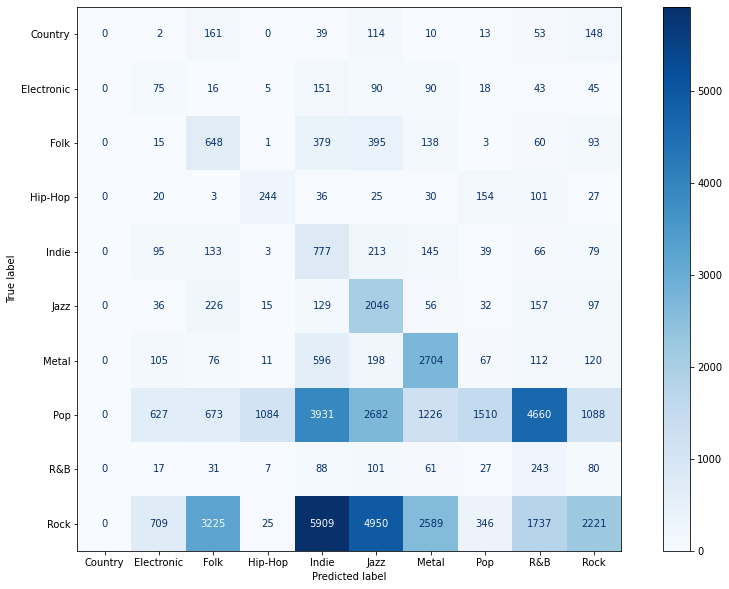

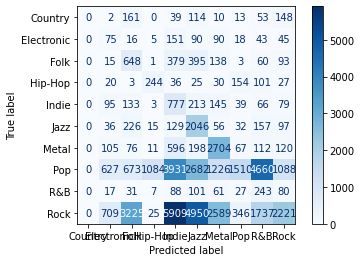

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(15,10))

cm=ConfusionMatrixDisplay.from_predictions(y_true_series, y_pred_series
                                        , cmap=plt.cm.Blues)
#plt.figure(figsize=(10, 10))
#plt.show()

cm.plot(ax=ax, cmap=plt.cm.Blues)

### Dropout=0.4

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.4
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    if (drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning) not in seen_parameter:
      seen_parameter.append((drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning))
      print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
      , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
      #step1
      roberta = TFAutoModel.from_pretrained('roberta-base')
      input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
      mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

      embeddings = roberta(input_ids, attention_mask= mask)[0]
      X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
      X = tf.keras.layers.BatchNormalization()(X)
      X = tf.keras.layers.Dense(128, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      X = tf.keras.layers.Dense(32, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

      model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
      model1.layers[2].trainable = False
      #model2.summary()

      #step2
      optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
      print(model1.summary() )#Check trainable params increased.

      #step3: transfer learning
      print("Fine tuning---------------")
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

      #step4: predict
      balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_transfer_learning.append( balanced_acc )

      #step5: fine tune
      model1.layers[2].trainable = True

      # It's important to recompile your model after you make any changes
      optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
      balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_fine_tuning.append( balanced_acc )
      print("----------------------------------------")
      del(model1)


In [ ]:
seen_parameter = []

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.5
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    if (drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning) not in seen_parameter:
      seen_parameter.append((drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning))
      print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
      , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
      #step1
      roberta = TFAutoModel.from_pretrained('roberta-base')
      input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
      mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

      embeddings = roberta(input_ids, attention_mask= mask)[0]
      X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
      X = tf.keras.layers.BatchNormalization()(X)
      X = tf.keras.layers.Dense(128, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      X = tf.keras.layers.Dense(32, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

      model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
      model1.layers[2].trainable = False
      #model2.summary()

      #step2
      optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
      print(model1.summary() )#Check trainable params increased.

      #step3: transfer learning
      print("Fine tuning---------------")
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

      #step4: predict
      balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_transfer_learning.append( balanced_acc )

      #step5: fine tune
      model1.layers[2].trainable = True

      # It's important to recompile your model after you make any changes
      optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
      balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_fine_tuning.append( balanced_acc )
      print("----------------------------------------")
      del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.5


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.00      0.00      0.00       533
         2.0       0.22      0.00      0.01      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.04      0.70      0.07      1550
         5.0       0.14      0.73      0.24      2794
         6.0       0.32      0.54      0.40      3989
         7.0       0.00      0.00      0.00     17481
         8.0       0.04      0.08      0.06       655
         9.0       0.41      0.01      0.02     21711

    accuracy                           0.11     51625
   macro avg       0.12      0.21      0.08     51625
weighted avg       0.21      0.11      0.06     51625

0.20698278871913095


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/6


10971/10971 [==============================] - 6110s 555ms/step - loss: 1.8617 - categorical_accuracy: 0.1376 - val_loss: 2.4529 - val_categorical_accuracy: 0.1770
Epoch 2/6
10971/10971 [==============================] - 6102s 556ms/step - loss: 1.7952 - categorical_accuracy: 0.1877 - val_loss: 2.4618 - val_categorical_accuracy: 0.1741
Epoch 3/6
10971/10971 [==============================] - 6117s 558ms/step - loss: 1.7463 - categorical_accuracy: 0.2306 - val_loss: 2.3069 - val_categorical_accuracy: 0.1969
Epoch 4/6
10971/10971 [==============================] - 6112s 557ms/step - loss: 1.6908 - categorical_accuracy: 0.2481 - val_loss: 2.3507 - val_categorical_accuracy: 0.1962
Epoch 5/6
10971/10971 [==============================] - 6113s 557ms/step - loss: 1.6582 - categorical_accuracy: 0.2508 - val_loss: 2.2194 - val_categorical_accuracy: 0.2164
Epoch 6/6
10971/10971 [==============================] - 6112s 557ms/step - loss: 1.6088 - categorical_accuracy: 0.2652 - val_loss: 2.2594 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.09      0.02      0.03       533
         2.0       0.16      0.00      0.01      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.64      0.10      1550
         5.0       0.20      0.79      0.32      2794
         6.0       0.48      0.60      0.53      3989
         7.0       0.49      0.29      0.37     17481
         8.0       0.03      0.30      0.06       655
         9.0       0.62      0.01      0.01     21711

    accuracy                           0.22     51625
   macro avg       0.21      0.26      0.14     51625
weighted avg       0.48      0.22      0.19     51625

0.26492577175314314


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------
learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.5


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.00      0.00      0.00       533
         2.0       0.17      0.01      0.02      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.45      0.09      1550
         5.0       0.19      0.60      0.28      2794
         6.0       0.15      0.82      0.26      3989
         7.0       1.00      0.00      0.00     17481
         8.0       0.03      0.28      0.05       655
         9.0       0.47      0.02      0.04     21711

    accuracy                           0.12     51625
   macro avg       0.21      0.22      0.08     51625
weighted avg       0.57      0.12      0.06     51625

0.2183374141421405


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/6


10971/10971 [==============================] - 6128s 557ms/step - loss: 1.8983 - categorical_accuracy: 0.1170 - val_loss: 2.4936 - val_categorical_accuracy: 0.1762
Epoch 2/6
10971/10971 [==============================] - 6102s 556ms/step - loss: 1.8673 - categorical_accuracy: 0.1255 - val_loss: 2.4482 - val_categorical_accuracy: 0.1849
Epoch 3/6
 7849/10971 [====================>.........] - ETA: 27:13 - loss: 1.9640 - categorical_accuracy: 0.1117

Resume from the last cell

In [ ]:
McNemar = {}
seen_parameter=[]

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.5
learning_rate_transfer_learnings = [1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    if (drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning) not in seen_parameter:
      seen_parameter.append((drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning))
      print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
      , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
      #step1
      roberta = TFAutoModel.from_pretrained('roberta-base')
      input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
      mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

      embeddings = roberta(input_ids, attention_mask= mask)[0]
      X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
      X = tf.keras.layers.BatchNormalization()(X)
      X = tf.keras.layers.Dense(128, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      X = tf.keras.layers.Dense(32, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

      model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
      model1.layers[2].trainable = False
      #model2.summary()

      #step2
      optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
      print(model1.summary() )#Check trainable params increased.

      #step3: transfer learning
      print("Fine tuning---------------")
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

      #step4: predict
      balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_transfer_learning.append( balanced_acc )

      #step5: fine tune
      model1.layers[2].trainable = True

      # It's important to recompile your model after you make any changes
      optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
      balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_fine_tuning.append( balanced_acc )
      print("----------------------------------------")
      del(model1)


learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.5


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

KeyboardInterrupt: ignored

Best parameter is dropout=0.3, 1e-3, 1e-5

### KFold test

Best parameter from Music4All is dropout=0.3, 1e-3, 1e-5 use this to test on kaggle dataset

In [ ]:
del(dataset_train)
del(dataset_test)
del(train)
del(val)
del(test)

### Fold0

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[0]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(206497,) (51625,)
Xids_train.shape, Xids_test.shape:  (206497, 256) (51625, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
McNemar={}
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []

In [ ]:
TEST_SIZE

51625

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
del(model1)


### Fold1: intentionally separate cells for check point purpose.

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[1]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(206497,) (51625,)
Xids_train.shape, Xids_test.shape:  (206497, 256) (51625, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
McNemar={}
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []

In [ ]:
TEST_SIZE

51625

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
10971/10971 [==============================] - 1523s 138ms/step - loss: 1.4817 - categorical_accuracy: 0.3435 - val_loss: 2.6233 - val_categorical_accuracy: 0.1191
Epoch 2/6
10971/10971 [==============================] - 1508s 137ms/step - loss: 1.4189 - categorical_accuracy: 0.3725 - val_loss: 2.6263 - val_categorical_accuracy: 0.1025
Epoch 3/6
10971/10971 [==============================] - 1507s 137ms/step - loss: 1.3946 - categorical_accuracy: 0.3673 - val_loss: 2.6287 - val_categorical_accuracy: 0.1322
Epoch 4/6
10971/10971 [==============================] - 1506s 137ms/step - loss: 1.3746 - categorical_accuracy: 0.3768 - val_loss: 2.6409 - val_categorical_accuracy: 0.1520
Epoch 5/6
10971/10971 [==============================] - 1505s 137ms/step - loss: 1.3641 - categorical_accuracy: 0.3730 - val_loss: 2.6014 - val_categorical_accuracy: 0.1454
Epoch 6/6
10971/10971 [==============================] - 1506s 137ms/step - loss: 1.3587 - categorical_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.00      0.00      0.00       533
         2.0       0.14      0.04      0.07      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.06      0.26      0.10      1550
         5.0       0.10      0.84      0.18      2795
         6.0       0.21      0.72      0.33      3988
         7.0       1.00      0.00      0.00     17481
         8.0       0.03      0.22      0.05       655
         9.0       0.33      0.04      0.07     21711

    accuracy                           0.13     51625
   macro avg       0.19      0.21      0.08     51625
weighted avg       0.51      0.13      0.07     51625

0.21253385312911677


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/6


10971/10971 [==============================] - 3453s 313ms/step - loss: 1.9089 - categorical_accuracy: 0.1173 - val_loss: 14.5913 - val_categorical_accuracy: 0.0420
Epoch 2/6
10971/10971 [==============================] - 3435s 313ms/step - loss: 1.9420 - categorical_accuracy: 0.1908 - val_loss: 3.4586 - val_categorical_accuracy: 0.0744
Epoch 3/6
10971/10971 [==============================] - 3434s 313ms/step - loss: 1.8235 - categorical_accuracy: 0.2497 - val_loss: 3.0752 - val_categorical_accuracy: 0.0850
Epoch 4/6
10971/10971 [==============================] - 3438s 313ms/step - loss: 1.8109 - categorical_accuracy: 0.2916 - val_loss: 5.8996 - val_categorical_accuracy: 0.0919
Epoch 5/6
10971/10971 [==============================] - 3439s 313ms/step - loss: 1.7497 - categorical_accuracy: 0.2930 - val_loss: 3.6838 - val_categorical_accuracy: 0.1257
Epoch 6/6
10971/10971 [==============================] - 3434s 313ms/step - loss: 1.7204 - categorical_accuracy: 0.3102 - val_loss: 2.5195 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.00      0.00      0.00       533
         2.0       0.00      0.00      0.00      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.00      0.00      0.00      1550
         5.0       0.32      0.68      0.43      2795
         6.0       0.42      0.59      0.49      3988
         7.0       0.00      0.00      0.00     17481
         8.0       0.02      0.61      0.04       655
         9.0       0.50      0.41      0.45     21711

    accuracy                           0.26     51625
   macro avg       0.13      0.23      0.14     51625
weighted avg       0.26      0.26      0.25     51625

0.22916268133435608
----------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fold2

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[2]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(206498,) (51624,)
Xids_train.shape, Xids_test.shape:  (206498, 256) (51624, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
McNemar = {}
balanced_accuracies_transfer_learning=[]
balanced_accuracies_fine_tuning=[]

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
TEST_SIZE=len(split0['y_test'])
balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )





learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
10971/10971 [==============================] - 1517s 137ms/step - loss: 1.4888 - categorical_accuracy: 0.3445 - val_loss: 2.6982 - val_categorical_accuracy: 0.1202
Epoch 2/6
10971/10971 [==============================] - 1499s 137ms/step - loss: 1.4240 - categorical_accuracy: 0.3693 - val_loss: 2.5165 - val_categorical_accuracy: 0.1672
Epoch 3/6
10971/10971 [==============================] - 1503s 137ms/step - loss: 1.3883 - categorical_accuracy: 0.3767 - val_loss: 2.4943 - val_categorical_accuracy: 0.1524
Epoch 4/6
10971/10971 [==============================] - 1499s 137ms/step - loss: 1.3733 - categorical_accuracy: 0.3747 - val_loss: 2.5845 - val_categorical_accuracy: 0.1370
Epoch 5/6
10971/10971 [==============================] - 1499s 137ms/step - loss: 1.3606 - categorical_accuracy: 0.3776 - val_loss: 2.5526 - val_categorical_accuracy: 0.1418


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.06      0.01      0.01       532
         2.0       0.21      0.01      0.02      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.45      0.09      1550
         5.0       0.15      0.72      0.25      2795
         6.0       0.15      0.81      0.25      3988
         7.0       0.75      0.00      0.00     17481
         8.0       0.04      0.08      0.05       655
         9.0       0.42      0.02      0.03     21711

    accuracy                           0.12     51624
   macro avg       0.18      0.21      0.07     51624
weighted avg       0.46      0.12      0.05     51624

0.20996877852778004


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

Resume from the last cell

In [ ]:
balanced_acc, McNemar, y_pred=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.06      0.01      0.01       532
         2.0       0.21      0.01      0.02      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.05      0.45      0.09      1550
         5.0       0.15      0.72      0.25      2795
         6.0       0.15      0.81      0.25      3988
         7.0       0.75      0.00      0.00     17481
         8.0       0.04      0.08      0.05       655
         9.0       0.42      0.02      0.03     21711

    accuracy                           0.12     51624
   macro avg       0.18      0.21      0.07     51624
weighted avg       0.46      0.12      0.05     51624

0.20996877852778004


Save the model for tesing genres overlapping on the music4all.

In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split2_transfer_learning')

In [ ]:
#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_pred=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")

Epoch 1/6


10971/10971 [==============================] - 3438s 312ms/step - loss: 1.8512 - categorical_accuracy: 0.1372 - val_loss: 3.0302 - val_categorical_accuracy: 0.1261
Epoch 2/6
10971/10971 [==============================] - 3415s 311ms/step - loss: 1.7930 - categorical_accuracy: 0.2002 - val_loss: 4.1127 - val_categorical_accuracy: 0.1062
Epoch 3/6
10971/10971 [==============================] - 3414s 311ms/step - loss: 1.7631 - categorical_accuracy: 0.2598 - val_loss: 3.0349 - val_categorical_accuracy: 0.1384
Epoch 4/6
10971/10971 [==============================] - 3409s 311ms/step - loss: 1.7241 - categorical_accuracy: 0.2682 - val_loss: 2.4148 - val_categorical_accuracy: 0.1878
Epoch 5/6
10971/10971 [==============================] - 3410s 311ms/step - loss: 1.6962 - categorical_accuracy: 0.2943 - val_loss: 3.0802 - val_categorical_accuracy: 0.1109
Epoch 6/6
10971/10971 [==============================] - 3410s 311ms/step - loss: 1.6915 - categorical_accuracy: 0.2792 - val_loss: 4.3611 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.00      0.00      0.00       532
         2.0       0.00      0.00      0.00      1732
         3.0       0.00      0.00      0.00       640
         4.0       0.03      0.94      0.06      1550
         5.0       0.23      0.63      0.34      2795
         6.0       0.00      0.00      0.00      3988
         7.0       0.00      0.00      0.00     17481
         8.0       0.00      0.00      0.00       655
         9.0       0.00      0.00      0.00     21711

    accuracy                           0.06     51624
   macro avg       0.03      0.16      0.04     51624
weighted avg       0.01      0.06      0.02     51624

0.15746344278377286


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------


In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_finetune')

In [ ]:
del(model1)

### Fold3

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[3]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(10832,) (2708,)
Xids_train.shape, Xids_test.shape:  (10832, 256) (2708, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar, y_predict =get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict = get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")



learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 95s 135ms/step - loss: 2.3718 - categorical_accuracy: 0.1891 - val_loss: 2.7436 - val_categorical_accuracy: 0.0790
Epoch 2/6
609/609 [==============================] - 80s 131ms/step - loss: 2.0907 - categorical_accuracy: 0.2326 - val_loss: 2.4798 - val_categorical_accuracy: 0.1296
Epoch 3/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9881 - categorical_accuracy: 0.2640 - val_loss: 2.3546 - val_categorical_accuracy: 0.1517
Epoch 4/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9432 - categorical_accuracy: 0.2827 - val_loss: 2.1311 - val_categorical_accuracy: 0.1654
Epoch 5/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9170 - categorical_accuracy: 0.2722 - val_loss: 2.1137 - val_categorical_accuracy: 0.2013
Epoch 6/6
609/609 [==============================] - 80s 132ms/step - loss: 1.9082 - categorical_accuracy: 0.2811 - val_loss: 2.0990 

609/609 [==============================] - 207s 313ms/step - loss: 1.8280 - categorical_accuracy: 0.2866 - val_loss: 1.8817 - val_categorical_accuracy: 0.2546
Epoch 2/6
609/609 [==============================] - 186s 306ms/step - loss: 1.7499 - categorical_accuracy: 0.3119 - val_loss: 1.8957 - val_categorical_accuracy: 0.2932
Epoch 3/6
609/609 [==============================] - 186s 306ms/step - loss: 1.6875 - categorical_accuracy: 0.3241 - val_loss: 2.0313 - val_categorical_accuracy: 0.2399
Epoch 4/6
609/609 [==============================] - 187s 306ms/step - loss: 1.6312 - categorical_accuracy: 0.3433 - val_loss: 1.8230 - val_categorical_accuracy: 0.3244
Epoch 5/6
609/609 [==============================] - 187s 306ms/step - loss: 1.5766 - categorical_accuracy: 0.3607 - val_loss: 1.7516 - val_categorical_accuracy: 0.3097
Epoch 6/6
609/609 [==============================] - 187s 307ms/step - loss: 1.5129 - categorical_accuracy: 0.3726 - val_loss: 1.7600 - val_categorical_accuracy: 0.2

In [ ]:
#convert integers to code
code2genre = {0: 'electronic'
              ,1: 'folk'
              ,2: 'indie pop'
              ,3: 'indie rock'
              ,4: 'pop'
              ,5: 'punk'
              ,6: 'rap'
              ,7: 'rock'
              ,8: 'singer-songwriter'
              ,9: 'soul'}

In [ ]:
set(y_predict)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
type(y_predict)

numpy.ndarray

In [ ]:
for i, pred in enumerate(y_predict):
  print(i,pred)
  #y_predict[i] = code2genre[pred]

for i, pred in enumerate(split0['y_test']):
  split0['y_test'][i] = code2genre[pred]

In [ ]:
split0=splits[3]

In [ ]:
y_pred_list = [0] * TEST_SIZE
for i, pred in enumerate(y_predict):
  y_pred_list[i] = code2genre[pred]

In [ ]:
Counter(split0['y_test'])

Counter({2: 134,
         4: 1036,
         9: 257,
         7: 290,
         5: 77,
         3: 216,
         8: 139,
         6: 196,
         0: 191,
         1: 172})

In [ ]:
y_true_list = []
for i, y_true in enumerate(split0['y_test']):
  y_true_list.append( code2genre[y_true] )

In [ ]:
Counter(y_true_list)

Counter({'indie pop': 134,
         'pop': 1036,
         'soul': 257,
         'rock': 290,
         'punk': 77,
         'indie rock': 216,
         'singer-songwriter': 139,
         'rap': 196,
         'electronic': 191,
         'folk': 172})

In [ ]:
y_pred_series = pd.Series(data = y_pred_list)
y_pred_series

0                    folk
1                    soul
2                    soul
3                    punk
4                    punk
              ...        
2703                 soul
2704    singer-songwriter
2705            indie pop
2706            indie pop
2707                  rap
Length: 2708, dtype: object

In [ ]:
y_true_series = pd.Series(data = y_true_list)
y_true_series

0        indie pop
1              pop
2             soul
3             rock
4             punk
           ...    
2703          soul
2704           pop
2705    electronic
2706     indie pop
2707           rap
Length: 2708, dtype: object

<Figure size 1440x1440 with 0 Axes>

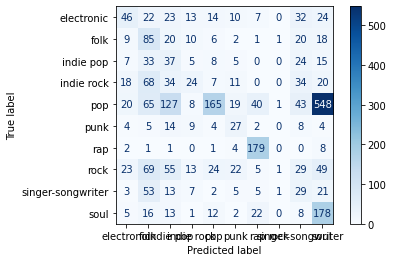

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(y_true_series, y_pred_series
                                        , cmap=plt.cm.Blues)

plt.show()

### Fold4

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[4]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(206498,) (51624,)
Xids_train.shape, Xids_test.shape:  (206498, 256) (51624, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
McNemar={}
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
TEST_SIZE=len(split0['y_test'])
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )




learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
10971/10971 [==============================] - 1510s 136ms/step - loss: 1.4913 - categorical_accuracy: 0.3448 - val_loss: 2.5861 - val_categorical_accuracy: 0.1143
Epoch 2/6
10971/10971 [==============================] - 1496s 136ms/step - loss: 1.4134 - categorical_accuracy: 0.3744 - val_loss: 2.7549 - val_categorical_accuracy: 0.1042
Epoch 3/6
10971/10971 [==============================] - 1495s 136ms/step - loss: 1.3881 - categorical_accuracy: 0.3756 - val_loss: 2.5798 - val_categorical_accuracy: 0.1484
Epoch 4/6
10971/10971 [==============================] - 1492s 136ms/step - loss: 1.3754 - categorical_accuracy: 0.3759 - val_loss: 2.5730 - val_categorical_accuracy: 0.1416
Epoch 5/6
10971/10971 [==============================] - 1491s 136ms/step - loss: 1.3677 - categorical_accuracy: 0.3731 - val_loss: 2.5638 - val_categorical_accuracy: 0.1435
Epoch 6/6
10971/10971 [==============================] - 1491s 136ms/step - loss: 1.3579 - categorical_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.00      0.00      0.00       533
         2.0       0.14      0.08      0.10      1732
         3.0       0.00      0.00      0.00       639
         4.0       0.05      0.51      0.09      1550
         5.0       0.11      0.82      0.19      2795
         6.0       0.31      0.58      0.40      3989
         7.0       0.86      0.00      0.00     17481
         8.0       0.04      0.14      0.06       654
         9.0       0.29      0.04      0.06     21711

    accuracy                           0.12     51624
   macro avg       0.18      0.22      0.09     51624
weighted avg       0.45      0.12      0.08     51624

0.21535215020463094


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split4_transfer_learning')

In [ ]:
#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
#del(model1)

Epoch 1/6


10971/10971 [==============================] - 3436s 312ms/step - loss: 1.8771 - categorical_accuracy: 0.1295 - val_loss: 2.9788 - val_categorical_accuracy: 0.0632
Epoch 2/6
10971/10971 [==============================] - 3421s 312ms/step - loss: 1.8275 - categorical_accuracy: 0.1929 - val_loss: 2.9946 - val_categorical_accuracy: 0.0813
Epoch 3/6
10971/10971 [==============================] - 3413s 311ms/step - loss: 1.7644 - categorical_accuracy: 0.2618 - val_loss: 2.4632 - val_categorical_accuracy: 0.1758
Epoch 4/6
10971/10971 [==============================] - 3410s 311ms/step - loss: 1.7459 - categorical_accuracy: 0.2844 - val_loss: 2.5228 - val_categorical_accuracy: 0.2400
Epoch 5/6
10971/10971 [==============================] - 3415s 311ms/step - loss: 1.7162 - categorical_accuracy: 0.2760 - val_loss: 2.4172 - val_categorical_accuracy: 0.2862
Epoch 6/6
10971/10971 [==============================] - 3413s 311ms/step - loss: 1.6988 - categorical_accuracy: 0.2868 - val_loss: 2.5024 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       540
         1.0       0.00      0.00      0.00       533
         2.0       0.00      0.00      0.00      1732
         3.0       0.00      0.00      0.00       639
         4.0       0.03      0.96      0.06      1550
         5.0       0.36      0.59      0.45      2795
         6.0       0.00      0.00      0.00      3989
         7.0       0.00      0.00      0.00     17481
         8.0       0.00      0.00      0.00       654
         9.0       0.00      0.00      0.00     21711

    accuracy                           0.06     51624
   macro avg       0.04      0.15      0.05     51624
weighted avg       0.02      0.06      0.03     51624

0.15492665474060824
----------------------------------------


split2->shplit4

In [ ]:
model1.save_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_kaggle_split2_finetuning')